In [88]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile
import json
from Bio import Align
from Bio.Seq import Seq
import itertools
import scipy
import sklearn
import skbio
import requests
from src.kegg import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Mapping
# bbmap.sh pigz=t unpigz=t ambiguous=random minid=0.96 idfilter=0.97 threads=64 out=stdout.sam editfilter=5 out=stdout.sam in1=/groups/banfield/sequences/2025/SR-VP_Bioreactor_ck_bot_05_06_2024_metaTSR-VP_Bioreactor_ck_bot_05_06_2024_metaT_trim_clean.PE.1.fastq.gz in2=/groups/banfield/sequences/2025/SR-VP_Bioreactor_ck_bot_05_06_2024_metaTSR-VP_Bioreactor_ck_bot_05_06_2024_metaT_trim_clean.PE.2.fastq.gz ref=genomes_file nodisk | shrinksam | sambam > SR-VP_Bioreactor_ck_bot_05_06_2024_metaT.bam

# Counting 
# featureCounts -p -T 64 -g ID -t CDS -a genomes.prot.gff (generated by prodigal) -s 2 -o SR-VP_Bioreactor_ck_bot_05_06_2024_metaT_reads_count SR-VP_Bioreactor_ck_bot_05_06_2024_metaT.bam

# Example of a read is GAAAGCCGCCGTCGCGGCATCAAGTGGAATGGAAACCGCAACAGAGGGGGACAGCAGAACATGGGTATTCGCGTACTGCTTGCCGACGATCATGTGATTGTGCGTCACGGTCTGGGCAGGGCCCTTCAGCAGGAAGACGACATGGAAGTC
# len('GAAAGCCGCCGTCGCGGCATCAAGTGGAATGGAAACCGCAACAGAGGGGGACAGCAGAACATGGGTATTCGCGTACTGCTTGCCGACGATCATGTGATTGTGCGTCACGGTCTGGGCAGGGCCCTTCAGCAGGAAGACGACATGGAAGTC')
# Seem to be length 150. 

In [90]:
# featureCounts -p -T 64 -g ID -t CDS -a ece_26_1334.gff -s 2 -o ./metat/n_bottom/ece_26_1334_read_counts.tsv ./metat/n_bottom/ece_26_1334.bam 
# featureCounts -p -T 64 -g ID -t CDS -a ece_26_1334.gff -s 2 -o ./metat/n_top/ece_26_1334_read_counts.tsv ./metat/n_top/ece_26_1334.bam 
# featureCounts -p -T 64 -g ID -t CDS -a ece_26_1334.gff -s 2 -o ./metat/n_middle/ece_26_1334_read_counts.tsv ./metat/n_middle/ece_26_1334.bam 
# featureCounts -p -T 64 -g ID -t CDS -a ece_26_1334.gff -s 2 -o ./metat/ck_bottom/ece_26_1334_read_counts.tsv ./metat/ck_bottom/ece_26_1334.bam 

# featureCounts -p -T 64 -g ID -t CDS -a n_top_methanoperedens.gff -s 2 -o ./metat/n_bottom/n_top_methanoperedens_read_counts.tsv ./metat/n_bottom/n_top_methanoperedens.bam 
# featureCounts -p -T 64 -g ID -t CDS -a n_top_methanoperedens.gff -s 2 -o ./metat/n_top/n_top_methanoperedens_read_counts.tsv ./metat/n_top/n_top_methanoperedens.bam 
# featureCounts -p -T 64 -g ID -t CDS -a n_top_methanoperedens.gff -s 2 -o ./metat/n_middle/n_top_methanoperedens_read_counts.tsv ./metat/n_middle/n_top_methanoperedens.bam 
# featureCounts -p -T 64 -g ID -t CDS -a n_top_methanoperedens.gff -s 2 -o ./metat/ck_bottom/n_top_methanoperedens_read_counts.tsv ./metat/ck_bottom/n_top_methanoperedens.bam 

# 
# featureCounts -p -T 64 -g ID -t CDS -a ck_bottom_methanoperedens.gff -s 2 -o ./metat/n_top/ck_bottom_methanoperedens_read_counts.tsv ./metat/n_top/ck_bottom_methanoperedens.bam 
# featureCounts -p -T 64 -g ID -t CDS -a ck_bottom_methanoperedens.gff -s 2 -o ./metat/n_middle/ck_bottom_methanoperedens_read_counts.tsv ./metat/n_middle/ck_bottom_methanoperedens.bam 
# featureCounts -p -T 64 -g ID -t CDS -a ck_bottom_methanoperedens.gff -s 2 -o ./metat/ck_bottom/ck_bottom_methanoperedens_read_counts.tsv ./metat/ck_bottom/ck_bottom_methanoperedens.bam 

In [91]:
ece_id = 'ece_26_1334'

In [92]:
def check_fasta_headers(path:str):
    '''Make sure the FASTA headers don't have any disallowed characters that interfere with the featureCounts program.
    This includes things like equals signs and spaces, basically just want the scaffold ID.'''
    pass

In [93]:
# Generate a script to submit the transcript-mapping jobs on Biotite. 

sample_paths = list()
sample_paths = ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_ck_bot_05_06_2024_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_ck_bot_05_17_2025_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_ck_mid_05_17_2025_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_ck_top_05_17_2025_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_N_bot_05_06_2024_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_N_bot_05_17_2025_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_N_top_05_06_2024_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_N_top_05_17_2025_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_N_mid_05_06_2024_metaT']
sample_paths += ['/groups/banfield/sequences/2025/SR-VP_Bioreactor_N_mid_05_17_2025_metaT']

sample_name_map = dict()
sample_name_map['SR-VP_Bioreactor_ck_bot_05_06_2024_metaT'] = 'ck_bottom_2024'
sample_name_map['SR-VP_Bioreactor_ck_bot_05_17_2025_metaT'] = 'ck_bottom_2025'
sample_name_map['SR-VP_Bioreactor_ck_mid_05_17_2025_metaT'] = 'ck_middle_2025'
sample_name_map['SR-VP_Bioreactor_ck_top_05_17_2025_metaT'] = 'ck_top_2025'
sample_name_map['SR-VP_Bioreactor_N_bot_05_06_2024_metaT'] = 'n_bottom_2024'
sample_name_map['SR-VP_Bioreactor_N_bot_05_17_2025_metaT'] = 'n_bottom_2025'
sample_name_map['SR-VP_Bioreactor_N_mid_05_06_2024_metaT'] = 'n_middle_2024'
sample_name_map['SR-VP_Bioreactor_N_mid_05_17_2025_metaT'] = 'n_middle_2025'
sample_name_map['SR-VP_Bioreactor_N_top_05_06_2024_metaT'] = 'n_top_2024'
sample_name_map['SR-VP_Bioreactor_N_top_05_17_2025_metaT'] = 'n_top_2025'

ref_paths = ['methanoperedens_1.fn', 'methanoperedens_2.fn', f'{ece_id}.fn']

def get_mapping_command(sample_path:str, ref_path:str=None, output_dir:str='./metat/'):
    # TODO: Should look into what paired-end reads are and how that works experimentally. 

    target_name = ref_path.replace('.fn', '')
    sample_name = os.path.basename(sample_path)
    input_path_1 = os.path.join(sample_path, 'raw.d', f'{sample_name}_trim_clean.PE.1.fastq.gz')
    input_path_2 = os.path.join(sample_path, 'raw.d', f'{sample_name}_trim_clean.PE.2.fastq.gz')

    output_path = os.path.join(output_dir, f'{sample_name_map[sample_name]}-{target_name}.bam')

    params = 'pigz=t unpigz=t ambiguous=random minid=0.96 idfilter=0.97 threads=64 out=stdout.sam editfilter=5 out=stdout.sam'
    cmd = f'bbmap.sh {params} in1={input_path_1} in2={input_path_2} ref={ref_path} nodisk | shrinksam | sambam > {output_path}'
    return cmd, output_path


def get_counting_command(bam_path:str, ref_path:str=None, output_dir:str='./metat/'):
    output_file_name = os.path.basename(bam_path).replace('.bam', '')
    output_file_name += '_read_counts'
    output_path = os.path.join(output_dir, output_file_name)

    cmd = f'featureCounts -p -T 64 -g ID -t CDS -a {ref_path} -s 2 -o {output_path} {bam_path}'
    return cmd 


def get_sbatch_command(cmd, job_name:str=None):
    return f'sbatch --wrap "{cmd}" --output ./slurm.out/{job_name}.out'

i = 0 

mapping_path, counting_path = 'metat_mapping.sh', 'metat_counting.sh'
mapping, counting = list(), list()
for ref_path in ref_paths:
    for sample_path in sample_paths:
        mapping_command, bam_path = get_mapping_command(sample_path, ref_path=ref_path)
        counting_command = get_counting_command(bam_path, ref_path=ref_path.replace('fn', 'gff'))
        mapping.append(get_sbatch_command(mapping_command, job_name=i))
        counting.append(counting_command)

        i += 1

with open(mapping_path, 'w') as f:
    f.write('\n'.join(mapping))

with open(counting_path, 'w') as f:
    f.write('\n'.join(counting))


In [96]:
def add_pseudocounts(metat_df:pd.DataFrame):
    '''Want to make sure to add pseudocounts based on everything in a sample, not just a particular organism!'''
    modified_metat_df = list()
    for _, df in metat_df.groupby('sample_name', group_keys=False):
        df['read_count_original'] = df.read_count.values # Mark the read counts which were corrected. 
        n = df.read_count.sum()
        df['read_count'] = skbio.stats.composition.multi_replace(df.read_count.values) * n
        modified_metat_df.append(df)
    return pd.concat(modified_metat_df)

def metat_load_data(metat_dir:str='../data/metat', read_length:int=150):

    metat_df = list()
    for path in glob.glob(os.path.join(metat_dir, '*read_counts')):
        file_name = os.path.basename(path)
        sample_name, target_name = file_name.replace('_read_counts', '').split('-')
        df = pd.read_csv(path, sep='\t', comment='#')
        columns = df.columns.tolist()
        columns[-1] = 'read_count'
        df.columns = [col.lower() for col in columns]
        df = df.rename(columns={'end':'stop', 'chr':'contig_id', 'geneid':'gene_id'})
        df['sample_name'] = sample_name
        df['target_name'] = target_name
        metat_df.append(df)
    metat_df = pd.concat(metat_df).reset_index(drop=True)
    metat_df = add_pseudocounts(metat_df)
    metat_df['coverage'] = read_length * metat_df.read_count / metat_df.length  
    # There should be one entry for each gene ID per sample. 
    # assert np.all(metat_df.value_counts(['sample_name', 'gene_id']) == 1), 'load_transcriptome_data: The gene IDs are not unique.'
    return metat_df

metat_df = metat_load_data()
metat_df

,gene_id,contig_id,start,stop,strand,length,read_count,sample_name,target_name,read_count_original,coverage
14886,1_1,Final_SR-VP_05_06_2024_coassembly_19kb_linear_...,268,564,+,297,16.998533,ck_bottom_2024,ece_26_1334,17,8.585118
14887,1_2,Final_SR-VP_05_06_2024_coassembly_19kb_linear_...,645,911,+,267,20.998188,ck_bottom_2024,ece_26_1334,21,11.796735
14888,1_3,Final_SR-VP_05_06_2024_coassembly_19kb_linear_...,960,1115,+,156,0.000740,ck_bottom_2024,ece_26_1334,0,0.000711
14889,1_4,Final_SR-VP_05_06_2024_coassembly_19kb_linear_...,1278,1424,+,147,5.999482,ck_bottom_2024,ece_26_1334,6,6.121921
14890,1_5,Final_SR-VP_05_06_2024_coassembly_19kb_linear_...,1562,1693,+,132,0.000740,ck_bottom_2024,ece_26_1334,0,0.000840
...,...,...,...,...,...,...,...,...,...,...,...
51650,61_1,SR-VP_05_06_2024_N_top_scaffold_857493,746,1003,+,258,0.000701,n_top_2025,methanoperedens_2,0,0.000408
51651,61_2,SR-VP_05_06_2024_N_top_scaffold_857493,987,1145,+,159,0.000701,n_top_2025,methanoperedens_2,0,0.000662
51652,62_1,SR-VP_05_06_2024_N_top_scaffold_914341,6,710,-,705,5.999122,n_top_2025,methanoperedens_2,6,1.276409
51653,62_2,SR-VP_05_06_2024_N_top_scaffold_914341,938,1102,-,165,0.000701,n_top_2025,methanoperedens_2,0,0.000638


In [ ]:
def filter_low_counts(metat_df, min_count:int=2, min_samples:int=3):
    '''Remove genes with counts less than min_count across at least 3 samples. This ensures there is enough expression to compare across samples.
    I do not normalize by library size here, which I am not sure if is the correct thing to do, but fuck it we ball.'''
    mask = metat_df.groupby('id').apply(lambda df : np.sum(df.groupby('sample_name').read_count.sum() >= min_count) >= min_samples, include_groups=False)
    keep_ids = metat_df.groupby('id').first().index
    keep_ids = keep_ids[mask].values
    print(f'filter_low_counts: Keeping {len(keep_ids)} out of {metat_df['id'].nunique()} total genes.')
    metat_df = metat_df[metat_df['id'].isin(keep_ids)].copy()
    return metat_df

metat_df = filter_low_counts(metat_df)

filter_low_counts: Keeping 2043 out of 5062 total genes.


Text(0.5, 0, 'ECE normalized coverage (CLR)')

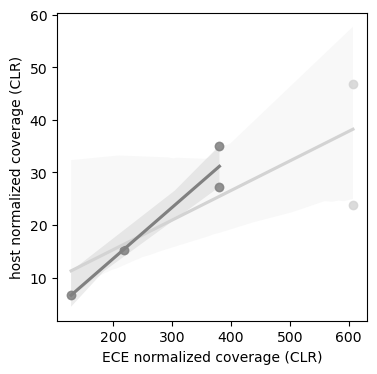

In [ ]:
# SR-VP_05_06_2024_N_top_Candidatus_Methanoperedens_Black-host_type_44_27 coverage is 27.22
# SR-VP_05_06_2024_ck_bottom_Methanoperedens_44_24 is 23.86

# Both of the confirmed hosts have taxonomy 'Black_host_Methanoperedens_contigs_Illumina_by_Np_final, Euryarchaeota, Archaea'
host_taxonomy = 'Black_host_Methanoperedens_contigs_Illumina_by_Np_final, Euryarchaeota, Archaea'

organism_info_df = pd.read_csv('sandbox-3_figure-1.csv')
organism_info_df = organism_info_df[(organism_info_df.taxonomy == host_taxonomy)| (organism_info_df.domain == ece_id)].copy()
organism_info_df['host'] = organism_info_df.taxonomy == host_taxonomy
organism_info_df = organism_info_df[~organism_info_df.metagenome_id.str.startswith('s')].copy() # Exclude environmental samples. 

figure_df = list()
for sample_name, df in organism_info_df.groupby('metagenome_id'):
    ece_coverage = df[~df.host].coverage.values[0]
    # ece_coverage = df[~df.host].normalized_coverage.values[0]
    for row in df[df.host].itertuples():
        # figure_df.append({'sample_name':'sample_name', 'ECE':ece_coverage, 'host':row.normalized_coverage})
        figure_df.append({'sample_name':sample_name, 'ECE':ece_coverage, 'host':row.coverage})
figure_df = pd.DataFrame(figure_df)

fig, ax = plt.subplots(figsize=(4, 4))
sns.regplot(figure_df, x='ECE', y='host', color='lightgray', ax=ax)
sns.regplot(figure_df[figure_df.sample_name.str.contains('n_')], x='ECE', y='host', color='gray', ax=ax)

ax.set_ylabel('host normalized coverage (CLR)')
ax.set_xlabel('ECE normalized coverage (CLR)')
# But there are other Methanoperedens genomes in the sample, so some of the reads could be mapping there?
# sns.scatterplot(df[df.name.str.contains('Methanoperedens')])

# Don't *really* trust the read depth stuff from the direct vernal pool samples, just because read depth is generally very low. 

In [ ]:
figure_df

,sample_name,ECE,host
0,ck_bottom,607.23,23.86
1,ck_bottom,607.23,46.70
2,n_bottom,128.92,6.66
3,n_middle,218.23,15.32
4,n_top,380.62,27.22
5,n_top,380.62,35.08


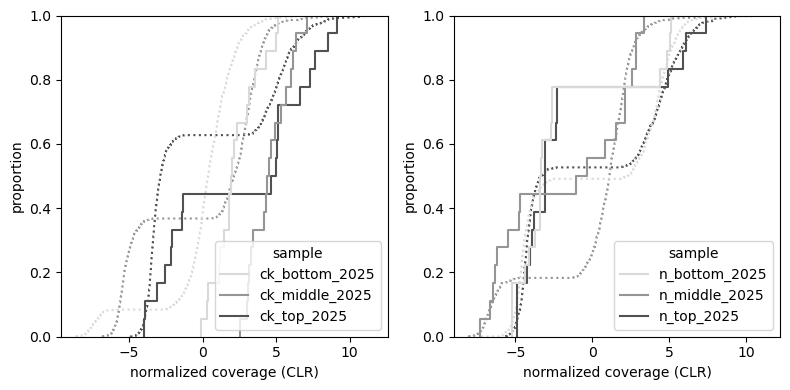

In [ ]:
# Can't apply CLR normalization to the transcript data without mapping to the entire metagenome, which would be outrageous. 
# What I *can* do is look within one sample and compare the distribution of mapped reads between the ECE and known host. 

# Despite being about 10 times more abundant than the host genome in the samples, the transcript activity on the ECE is similar to that of 
# most of the host genes. Not completely sure how to rationalize this. Perhaps implies that there is a lot that's not actually associated with a cell?

figure_df = metat_df.copy()
figure_df = figure_df[figure_df.target_name.isin([ece_id, 'methanoperedens_2'])].copy() # More reads map to the second genome, and I think it is more complete. 
figure_df['host'] = figure_df.target_name != ece_id

# I need to normalize the data somehow to facilitate comparison across samples. Using the Methanoperedens transcript data from each sample as a way
# to normalize, which involves using the assumption that Methanoperedens versus ECE abundance is relatively fixed across samples. 
clr_mean = {sample_name:np.log(scipy.stats.gmean(df[df.host].coverage)) for sample_name, df in figure_df.groupby('sample_name')}
figure_df['clr_mean'] = figure_df.sample_name.map(clr_mean)
figure_df['normalized_coverage'] = np.log(figure_df.coverage) - figure_df.clr_mean

def plot_coverage_ecdf(figure_df, ax=plt.Axes, year='2025', nutrients='ck_'):
    sample_names = [sample_name for sample_name in figure_df.sample_name.unique() if year in sample_name]
    sample_names = [sample_name for sample_name in sample_names if nutrients in sample_name]
    figure_df['sample'] = figure_df['sample_name']

    sns.ecdfplot(figure_df[(figure_df.host) & (figure_df.sample_name.isin(sample_names))], x='normalized_coverage', color='lightgray', hue='sample', ls=':', palette='Grays', ax=ax)
    sns.ecdfplot(figure_df[(~figure_df.host) & (figure_df.sample_name.isin(sample_names))], x='normalized_coverage', hue='sample', palette='Grays', ax=ax)
    # ax.set_xlim(xmin=-1, xmax=3)
    # ax.set_ylim(ymin=0)
    # ax.get_legend().set_title('')
    ax.set_ylabel('proportion')
    ax.set_xlabel('normalized coverage (CLR)')

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

plot_coverage_ecdf(figure_df, ax=axes[0], nutrients='ck_')
plot_coverage_ecdf(figure_df, ax=axes[1], nutrients='n_')

fig.tight_layout()
plt.show()


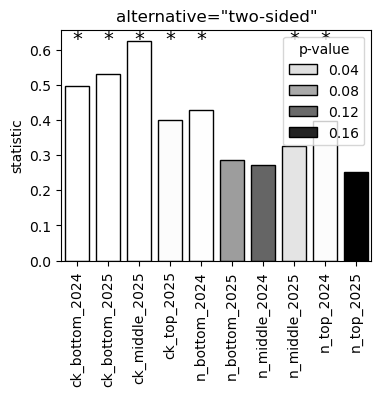

Sample ck_bottom_2024, p-value 0.00015224801433103626
Sample ck_bottom_2025, p-value 3.628693394508856e-05
Sample ck_middle_2025, p-value 3.3004288536472004e-07
Sample ck_top_2025, p-value 0.0046207745018818904
Sample n_bottom_2024, p-value 0.0019055402987725241
Sample n_bottom_2025, p-value 0.0873523960601327
Sample n_middle_2024, p-value 0.12319173950732085
Sample n_middle_2025, p-value 0.03460661472225508
Sample n_top_2024, p-value 0.0049485494977480745
Sample n_top_2025, p-value 0.18189545912934704


In [ ]:
# Characterize patterns across samples with Kolmogorov-Smirnov test. If one-sided, it will q
fig, ax = plt.subplots(figsize=(4, 3))

# We are testing to see if the ECE transciption is greater than the host, with the null being that it is less than the host. 
# For alternative='greater': The null hypothesis is that F(x) <= G(x) for all x; the alternative is that F(x) > G(x) for at least one x.

alternative = 'two-sided'
# alternative = 'less'
get_ks_result = lambda df : scipy.stats.kstest(df[~df.host].normalized_coverage.values, df[df.host].normalized_coverage.values, alternative=alternative)

ax_df = pd.DataFrame(index=pd.Series(figure_df.sample_name.unique(), name='sample_name'))
ax_df['p_value'] = figure_df.groupby('sample_name').apply(lambda df : get_ks_result(df).pvalue, include_groups=False)
ax_df['statistic'] = figure_df.groupby('sample_name').apply(lambda df : get_ks_result(df).statistic, include_groups=False)
signficant_samples = ax_df.index[ax_df.p_value < 0.05].values

ax_df = ax_df.sort_values('sample_name')
sns.barplot(ax_df, x='sample_name', y='statistic', hue='p_value', palette='Grays', edgecolor='black')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

for x, label in zip(ax.get_xticks(), ax.get_xticklabels()):
    if label.get_text() in signficant_samples:
        ax.text(x, ax.get_ylim()[-1], '*', ha='center', va='top', fontsize=14)

ax.set_xlabel('')
ax.get_legend().set_title('p-value')
ax.set_title(f'alternative="{alternative}"')
plt.show()

for row in ax_df.itertuples():
    print(f'Sample {row.Index}, p-value {row.p_value}')

In [ ]:
# How does Methanoperedens metabolism change in each condition?
# Should I compare bottom to bottom and top to top?

# CLR is good for counts, because it assumes the input data is compositional. However, coverage is no longer compositional, as it
# controls for gene length. I think it is still the best option here, because I want to preserve the ratios. 

def get_clr_normalization(metat_df):
    # I think I want to normalize by genome and by sample in order to figure out differential regulation... 
    assert metat_df.target_name.nunique() == 1, 'get_clr_normalization: Expected only one target genome in the DataFrame.'
    clr_mean = {sample_name:np.log(scipy.stats.gmean(df.coverage)) for sample_name, df in metat_df.groupby('sample_name')}
    metat_df['clr_mean'] = metat_df.sample_name.map(clr_mean)
    # Should not ba adding zero here, because it distorts the ratios. Instead, use multiplicative zero replacement, which keeps ratios of the nonzero elements the same.
    metat_df['normalized_coverage'] = np.log(metat_df.coverage) - metat_df.clr_mean
    return metat_df

host_metat_df = metat_df[metat_df.target_name == 'methanoperedens_2'].copy()
host_metat_df['nitrate'] = host_metat_df.sample_name.str.startswith('n_')
host_metat_df = get_clr_normalization(host_metat_df)

print(f'Num. unique genes: {host_metat_df['id'].nunique()}')

Num. unique genes: 1125


In [ ]:
pathways = dict()
pathways['map00680'] = 'methane metabolism'
pathways['map01310'] = 'nitrogen cycle  '
pathways['map00910'] = 'nitrogen metabolism'

def load_kos(pathway, kegg_dir='../data/kegg'):
    path = os.path.join(kegg_dir, f'{pathway}.tsv')
    df = pd.read_csv(path, sep='\t', names=['id', 'ko'])
    kos =  df.ko.values.tolist()
    kos = [ko.split(':')[-1] for ko in kos]
    return kos

map00910_kos = load_kos('map00910')
map00680_kos = load_kos('map00680')

cols = ['id', 'ko', 'threshold', 'score', 'e_value', 'definition']
kegg_df = pd.read_csv('../data/kegg/methanoperedens_2_kegg.tsv', sep='\t', comment='#', names=cols, header=None)
kegg_df['*'] = kegg_df['id'].str.startswith('*') # Marks if the annotation meets the threshold. 
kegg_df['id'] = kegg_df['id'].str.replace('*', '', regex=False)
kegg_df['id'] = [id_.split('|')[0].strip() for id_ in kegg_df['id']]
kegg_df['nitrate_metabolism'] = kegg_df.ko.isin(map00910_kos)
kegg_df['methane_metabolism'] = kegg_df.ko.isin(map00680_kos)

id_to_ko_map = kegg_df.sort_values('e_value').drop_duplicates('id').set_index('id').ko.to_dict()

map00680_ids = kegg_df[kegg_df.ko.isin(map00680_kos)]['id'].values.tolist()
map00910_ids = kegg_df[kegg_df.ko.isin(map00910_kos)]['id'].values.tolist()

print('Num. genes with a KO group:', kegg_df['id'].nunique(), 'out of', host_metat_df['id'].nunique())
print('Num. KO groups:', kegg_df['ko'].nunique())
print('Num. genes involved in methane metabolism:', len(map00680_ids))
print('Num. genes involved in nitrogen metabolism:', len(map00910_ids))

Num. genes with a KO group: 1104 out of 1125
Num. KO groups: 952
Num. genes involved in methane metabolism: 96
Num. genes involved in nitrogen metabolism: 8


In [ ]:
ko_to_pathway_map = kegg_get_pathways_by_ko(kegg_df.ko.unique())
ko_to_module_map, module_to_ko_map = kegg_get_modules_by_ko(kegg_df.ko.unique())
module_name_map = {module:kegg_get_module(module) for module in module_to_ko_map.keys()}
ko_name_map = kegg_df.drop_duplicates('ko').set_index('ko').definition.to_dict()

Explained variance: [0.28924156 0.26179624]


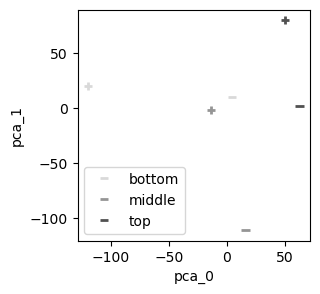

In [ ]:
year = '2025'

# pca_df = host_metat_df[['nitrate', 'id', 'normalized_coverage', 'sample_name']].copy()
pca_df = host_metat_df[['nitrate', 'geneid', 'normalized_coverage', 'sample_name']].copy()
pca_df = pca_df[pca_df.sample_name.str.contains(year)].copy()
pca_df = pca_df.pivot(columns='geneid', values='normalized_coverage', index='sample_name')

values = pca_df.values 
# values = sklearn.preprocessing.StandardScaler().fit_transform(values)

pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(values)

print(f'Explained variance: {pca.explained_variance_ratio_}')

components = pca.fit_transform(values).T

figure_df = pd.DataFrame(index=pca_df.index)
for i in range(len(components)):
    figure_df[f'pca_{i}'] = components[i]
figure_df['sample_name'] = figure_df.index
figure_df['nitrate'] = figure_df.index.str.startswith('n_')
figure_df['nitrate'] = np.where(figure_df.nitrate, '+', '-')

get_sample_location = lambda sample_name : re.search('top|bottom|middle', sample_name).group(0)
figure_df['location'] = figure_df.sample_name.apply(get_sample_location)

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(figure_df[figure_df.nitrate == '+'], x='pca_0', y='pca_1', hue='location', palette='Grays', marker='+', linewidth=2, legend=False)
sns.scatterplot(figure_df[figure_df.nitrate == '-'], x='pca_0', y='pca_1', hue='location', palette='Grays', marker='_', linewidth=2, legend=True)
ax.get_legend().set_title('')
sns.move_legend(ax, loc='lower left')

plt.show()

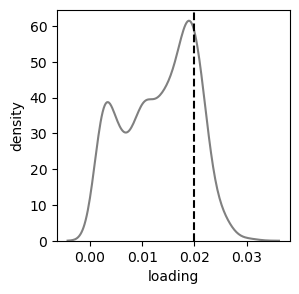

Num. features with importance > 0.02: 198


In [ ]:
threshold = 0.02

loadings = pca.components_ # Components are the eigenvectors, which shape (n_components, n_features). Not sure why we need to take the absolute value?
# To get the feature importance, need the loadings scaled by the explained variance ratio (probably regular explained variance would also work)
loadings = np.abs(loadings) * pca.explained_variance_ratio_.reshape(-1, 1) # End up with a 1125 by 5 matrix; this is broadcasting, not matrix multiplication. 
loadings = loadings.sum(axis=0) # Get total importance of each feature. 

n_features = pca_df.shape[-1]
figure_df = pd.DataFrame(index=np.arange(n_features))
figure_df['gene_id'] = pca_df.columns 
figure_df['loading'] = loadings
figure_df['ko'] = figure_df['gene_id'].map(id_to_ko_map)
figure_df['ko_name'] = figure_df.ko.map(ko_name_map)

fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(figure_df, x='loading', color='gray')
ax.set_ylabel('density')
ax.axvline(threshold, ls='--', color='black')
plt.show()
print(f'Num. features with importance > {threshold}:', (figure_df.loading > threshold).sum())
important_ids = figure_df[figure_df.loading > threshold].sort_values('loading')['gene_id'].unique()




In [ ]:
# What am I going to use as a reference? Thinking about doing a heatmap with genes on the y-axis, and then each x-axis value is a measure in 
# a nitrate plus sample relative to one of the controls. 4 "controls",  "treatment groups." So 20 total comparisons to make. 
n_sample_names = metat_df.sample_name[metat_df.sample_name.str.startswith('n_')].unique()
ck_sample_names = metat_df.sample_name[~metat_df.sample_name.str.startswith('n_')].unique()


def get_differential_expression(metat_df:pd.DataFrame, control_sample_names=ck_sample_names):
    '''Limited by the fact that I don't have true technical replicates.'''
    # Each row is a gene and each column is the expression level of that gene in the sample.
    df = metat_df.pivot(columns='sample_name', values='normalized_coverage', index='geneid').copy()
    df = df.reset_index()

    sample_names = [sample_name for sample_name in metat_df.sample_name.unique() if (sample_name not in control_sample_names)]

    diff_df = list()
    # for sample_name, control_sample_name in itertools.product(sample_names, control_sample_names):
    #     diff_df += [{'id':row['id'], 'delta':row[sample_name] - row[control_sample_name], 'control_sample_name':control_sample_name, 'sample_name':sample_name} for row in df.to_dict(orient='records')]
    for sample_name, control_sample_name in itertools.product(sample_names, control_sample_names):
        diff_df += [{'gene_id':row['geneid'], 'delta':row[sample_name] - row[control_sample_name], 'control_sample_name':control_sample_name, 'sample_name':sample_name} for row in df.to_dict(orient='records')]

    diff_df = pd.DataFrame(diff_df)
    return diff_df

diff_df = get_differential_expression(host_metat_df)

In [ ]:
def metat_get_gene_ids_from_reference(df:pd.DataFrame, ref_path:str='../data/methanoperedens_2.gff'):
    '''The GFF file used to map the RNA transcripts was generated by Prodigal from the raw FASTA nucleotide file, and I was worried that there
    might be differences between the gene IDs assigned here and the gene IDs assigned during the earlier metagenome-mode Prodigal run. 
    To address this, I directly mapped the gene IDs in the reference GFF file to the genes in the input DataFrame using start and stop positions.'''

    cols = ['contig_id', 'version', 'feature_type', 'start', 'stop', 'score', 'strand', 'frame', 'description']
    gff_df = pd.read_csv(ref_path, comment='#', sep='\t', names=cols)
    # The GFF file is what was used to map the reads, so need to make sure the proteins line up. 

    def get_gene_id(row):
        mask = (df.start == row.start) & (df.end == row.stop) & (df.strand == row.strand) & (df.chr == row.contig_id)
        if len(df[mask]) > 0:
            return df['geneid'].values[0]
        else:
            return 'none'

host_df = GenBankFile.from_file('../data/methanoperedens_2.gbk').to_df()
host_df['product'] = np.where(host_df['product'].str.contains('Tax='), 'hypothetical protein', host_df['product']) # Clean up the hypothetical protein names.
host_df['gene_id'] = [get_gene_id(row) for row in host_df.itertuples()]
host_df = host_df[host_df.gene_id != 'none'].copy()

In [ ]:
def check_genbank_file(df:pd.DataFrame, fa_path:str='../data/methanoperedens_2.faa'):
    fa_df = FASTAFile.from_file(fa_path).to_df(parse_description=False)
    fa_df.index = [id_.split('|')[0] for id_ in fa_df.index]
    fa_ids = fa_df.index.values
    gbk_ids = df.locus_tag.unique()
    assert len(np.intersect1d(gbk_ids, fa_ids)) == len(fa_ids), 'check_genbank_file'

# check_genbank_file(host_df)

<Axes: xlabel='name'>

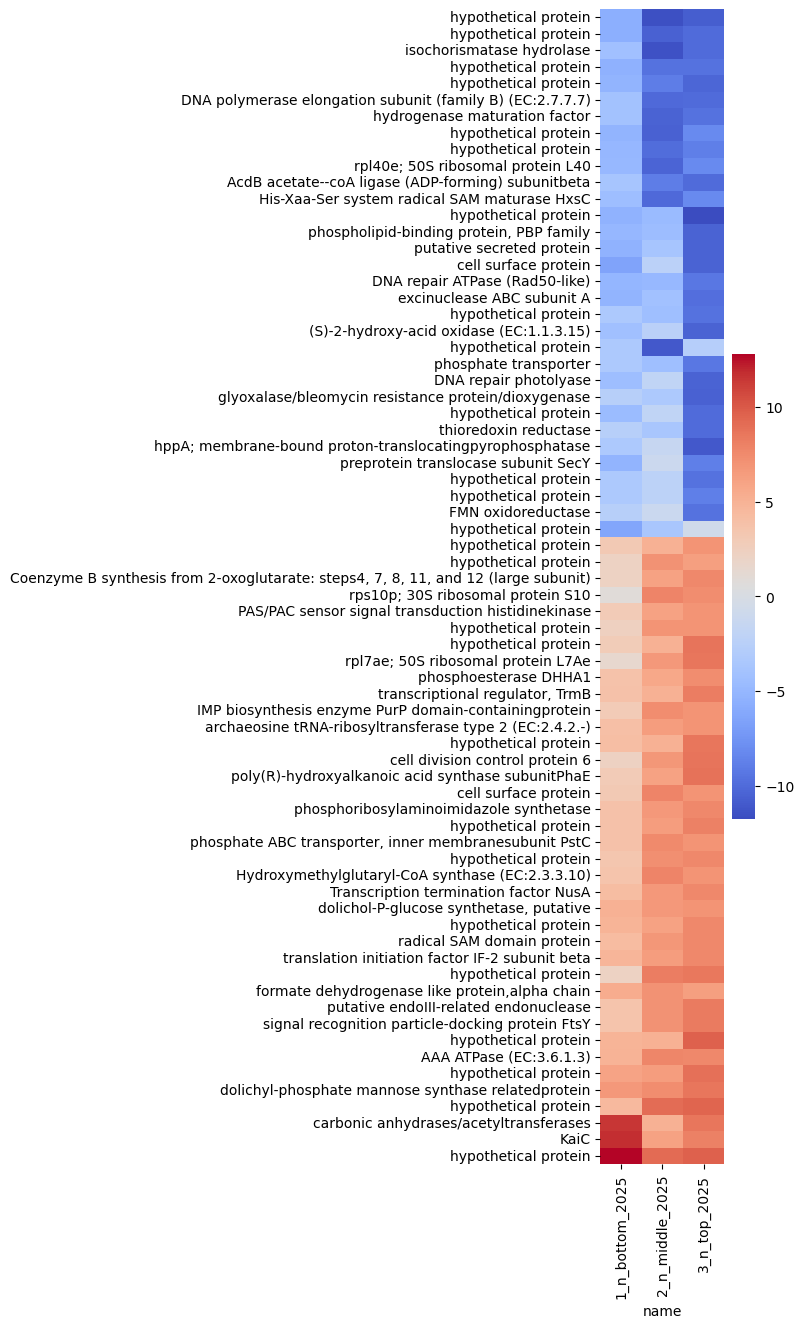

In [ ]:
get_sample_location = lambda sample_name : re.search('top|bottom|middle', sample_name).group(0)

fig, ax = plt.subplots(figsize=(2, 15))

control_sample_name_map = {control_sample_name:i for i, control_sample_name in enumerate(ck_sample_names)}
has_consistent_regulation = lambda df : np.all(np.sign(df.delta.values) == np.sign(df.delta.values)[0])

figure_df = diff_df.copy()
figure_df = figure_df[figure_df.control_sample_name.str.contains(year) & figure_df.sample_name.str.contains(year)].copy()
figure_df = figure_df[figure_df.control_sample_name.apply(get_sample_location) == figure_df.sample_name.apply(get_sample_location)].copy()
figure_df['consistent_regulation'] = figure_df['gene_id'].map(figure_df.groupby('gene_id').apply(has_consistent_regulation, include_groups=False))
figure_df = figure_df[figure_df.consistent_regulation].copy()

# figure_df['name'] = [f'{sample_name}_{control_sample_name_map[control_sample_name]}' for sample_name, control_sample_name in zip(diff_df.sample_name, diff_df.control_sample_name)]
figure_df['name'] = [f'{control_sample_name_map[control_sample_name]}_{sample_name}' for sample_name, control_sample_name in zip(figure_df.sample_name, figure_df.control_sample_name)]
figure_df = figure_df.pivot(columns='name', values='delta', index='gene_id').copy()
figure_df = figure_df[figure_df.index.isin(important_ids)].copy()
# figure_df.index = figure_df.index.map(id_to_ko_map).map(ko_name_map)
# figure_df.index = figure_df.index.map(host_df.set_index('locus_tag')['product'])
figure_df.index = figure_df.index.map(host_df.set_index('gene_id')['product'])
figure_df.index = np.where(figure_df.index.isnull(), 'none', figure_df.index)
figure_df['mean'] = figure_df.values.mean(axis=1).ravel()
figure_df = figure_df.sort_values(by='mean') # Sort by the average delta across all samples.. 

sns.heatmap(figure_df.drop(columns='mean'), cmap='coolwarm')

# It seems likely that a lot of what PCA is capturing is the variance between locations, not between samples. 

In [ ]:
# df = host_metat_df.pivot(columns='sample_name', values='normalized_coverage', index='id').copy()
# # df.columns = df.columns.get_level_values(1)
# df = df.reset_index()

# n_sample_names = host_metat_df.sample_name[host_metat_df.sample_name.str.startswith('n_')].unique()
# ck_sample_names = host_metat_df.sample_name[~host_metat_df.sample_name.str.startswith('n_')].unique()

# diff_df = list()
# for n_sample_name, ck_sample_name in itertools.product(n_sample_names, ck_sample_names):
#     # diff_df += [{'id':row['id'], 'diff':row[n_sample_name] - row[ck_sample_name], 'ck_sample_name':ck_sample_name, 'n_sample_name':n_sample_name} for row in df.to_dict(orient='records')]
# diff_df = pd.DataFrame(diff_df)

# # Perhaps shouldn't trust the genes with a high degree of variance in their differential expression. 

# # ChaTGPT suggested using median absolute deviation instead, which is more robust to outliers. 
# # Could take two approaches: remove outlier samples, or just remove entire genes. 

# # MAD score on its own does not capture directional consistency, which is resulting in poor filtering. 
# # Also want to make sure that the majority of samples have the same sign, i.e. a gene is either up- or down- regulated, not both. 
# is_consistently_regulated = lambda df : np.all(np.sign(df['diff'].values) == np.sign(df['diff'].values)[0])
# threshold = 0.7
# is_consistently_regulated = lambda df : (np.sign(df['diff'].values) == np.sign(df['diff'].values)[0]).mean() > threshold
                                       
# # First compute the mean absolute deviation for a given sample, which is essentially the median of the difference between the values and the median. 
# diff_df['sample_median'] = diff_df['id'].map(diff_df.groupby('id')['diff'].median())
# diff_df['consistently_regulated'] = diff_df['id'].map(diff_df.groupby('id').apply(is_consistently_regulated, include_groups=False))
# diff_df['diff_minus_sample_median'] = np.abs(diff_df['diff'] - diff_df.sample_median)
# diff_df['median_absolute_deviation'] = diff_df['id'].map(diff_df.groupby('id').diff_minus_sample_median.median())
# diff_df['median_absolute_deviation_z_score'] = diff_df.diff_minus_sample_median / diff_df.median_absolute_deviation
# diff_df['std'] = diff_df['id'].map(diff_df.groupby('id')['diff'].std())

# threshold = 3
# # print('Num. genes with the standard deviation exceeding the threshold:', diff_df[(diff_df['std'] > threshold)]['id'].nunique())
# print('Num. total genes:', diff_df['id'].nunique())
# print('Num. values with the MAD score exceeding the threshold:', (diff_df.median_absolute_deviation_z_score > threshold).sum())
# print('Num. genes with the MAD score exceeding the threshold in at least one sample:', diff_df[diff_df.median_absolute_deviation_z_score > threshold]['id'].nunique())

# variable_ids = diff_df[(diff_df.median_absolute_deviation_z_score > threshold)]['id'].unique().tolist()
# variable_ids += diff_df[~diff_df.consistently_regulated]['id'].unique().tolist()

# mask = ~diff_df['id'].isin(variable_ids)
# print('Num. samples removed:', (~mask).sum(), 'out of', len(diff_df))
# # diff_df = diff_df[diff_df.median_absolute_deviation_z_score <= threshold].copy()
# diff_df = diff_df[mask].copy()

<unknown>:64: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.


In [ ]:
# fig, ax = plt.subplots(figsize=(4, 4))

# upregulated_threshold = 3
# downregulated_threshold = -3

# diff_df['upregulated'] = diff_df['diff'] > upregulated_threshold
# diff_df['downregulated'] = diff_df['diff'] < downregulated_threshold
# diff_df['ko'] = diff_df['id'].map(kegg_df.sort_values('e_value').drop_duplicates('id').set_index('id').ko)
# diff_df['module'] = diff_df.ko.map({ko:map_[0] for ko, map_ in ko_to_module_map.items()}) # Just get the first module for now. 
# diff_df['module_description'] = diff_df.module.map(module_name_map)
# diff_df['ko_description'] = diff_df.ko.map(ko_name_map)
# diff_df['regulation'] = np.select([diff_df.upregulated, diff_df.downregulated], ['+', '-'], default='.')
# diff_df = diff_df.fillna('none')

# upregulated_ids = diff_df[diff_df.upregulated]['id'].unique()
# downregulated_ids = diff_df[diff_df.downregulated]['id'].unique()
# assert len(np.intersect1d(upregulated_ids, downregulated_ids)), 'There are genes marked as both significantly up- and down- regulated.'

# print('Num. genes upregulated:', len(upregulated_ids))
# print('Num. genes downregulated:', len(downregulated_ids))

# sns.kdeplot(diff_df, x='diff', color='gray')
# ax.set_ylabel('density')
# plt.show()

In [ ]:
# # Some Kegg Ortho groups are not associated with pathways. 
# upregulated_pathways = [pathway for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_pathway_map) for pathway in ko_to_pathway_map[ko]]
# downregulated_pathways = [pathway for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_pathway_map) for pathway in ko_to_pathway_map[ko]]

# # upregulated_modules = [mod for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_module_map) for mod in ko_to_module_map[ko]]
# # downregulated_modules = [mod for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_module_map) for mod in ko_to_module_map[ko]]
# upregulated_modules = [ko_to_module_map[ko][0] for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_module_map)]
# downregulated_modules = [ko_to_module_map[ko][0] for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_module_map)]

# min_count = 1
# figure_df = [{'module':mod, 'category':'upregulated'} for mod in upregulated_modules]
# figure_df += [{'module':mod, 'category':'downregulated'} for mod in downregulated_modules]
# figure_df = pd.DataFrame(figure_df)
# # figure_df = figure_df[figure_df.module.str.startswith('map')].copy()
# figure_df = figure_df[figure_df.module.str.startswith('M')].copy()
# figure_df['count'] = figure_df.module.map(figure_df.module.value_counts())
# figure_df = figure_df[figure_df['count'] > min_count].copy()

# fig, ax = plt.subplots(figsize=(10, 4))
 
# sns.histplot(figure_df, x='module', hue='category', multiple='dodge', palette='Grays')
# labels = [module_name_map[module.get_text()] for module in ax.get_xticklabels()]
# labels = [label.split(',')[0] for label in labels]
# ax.set_xticks(ax.get_xticks(), labels, rotation=90)
# ax.set_xlabel('')
# ax.get_legend().set_title('')
# plt.show()

In [ ]:
diff_df[diff_df.module_description.str.contains('Urea')].sort_values('ko_description')

AttributeError: 'DataFrame' object has no attribute 'module_description'

In [ ]:
figure_df.pathway.value_counts()

AttributeError: 'DataFrame' object has no attribute 'pathway'

In [ ]:
# # First want to compare the Methanoperedens read counts and ECE read counts across samples. 

# figure_df = list()

# for sample_name, df in metat_df.groupby('sample_name'):
#     for i in range(1, 3):
#         row = {'methanoperedens_id':i, 'sample_name':sample_name}
#         row['Methanoperedens'] = df[df.target_name == f'methanoperedens_{i}'].coverage.mean()
#         row['ECE'] = df[df.target_name == ece_id].coverage.mean()
#         figure_df.append(row)
# figure_df = figure_df[figure_df.methanoperedens_id == 2].copy() # values for 2 are consistently higher, maybe the genome is more complete. 
# figure_df = pd.DataFrame(figure_df)
# # figure_df = figure_df[figure_df.sample_name.str.startswith('n')].copy() # Nitrate samples only, for now. 
# # figure_df['sample_location'] = [re.search('top')]

# sns.scatterplot(figure_df, x='ECE', y='Methanoperedens', legend=True, hue='methanoperedens_id')
# # sns.scatterplot(figure_df, x='ECE', y='Methanoperedens', hue='methanoperedens_id', legend=False, palette={1:'gray', 2:'darkgray'})


In [ ]:
# figure_df = metat_df.copy()
# figure_df['category'] = np.where(metat_df.target_name.str.contains('methanoperedens'), 'host', 'ECE')

# for sample_name, df in figure_df.groupby('sample_name'):
#     print(f'Percentage of genes with no mapped reads in sample {sample_name}: {100 * (df.coverage == 0).sum() / len(df):.2f}%')
# # figure_df = figure_df[figure_df.coverage > 0].copy()

# fig, axes = plt.subplots()
# sns.ecdfplot(figure_df, x='coverage', hue='sample_name', palette='Grays')
# ax.set_xlim(xmin=0, xmax=5)

# # How to go about normalizing this? Differences in ECE and Methanoperedens read counts might be related to differing numbers of each group 
# # in the sample